In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Pauli, Statevector, Operator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2 # Retired quantum processor
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [2]:
import sys
import os

In [12]:
backend_name = "aer" #manila, aer
trotter_order= "first" #first, second

In [13]:
import qiskit 
qiskit.version.get_version_info() 

'1.1.1'

In [14]:
import qiskit_ibm_runtime 
qiskit_ibm_runtime .version.get_version_info() 

'0.24.1'

In [15]:
# Determine the correct path for the 'src' directory
if '__file__' in globals():
    # Running as a script
    src_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'src'))
else:
    # Running in an interactive environment like Jupyter Notebook
    src_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

sys.path.append(src_dir)

In [16]:

from hamiltonian import construct_hamiltonian
from evolve import evolve_and_measure_circuit
from constants import hbar, c , eV, MeV, GeV, G_F, kB

In [17]:
def initialize_parameters():
    N_sites = 4 # Number of qubits
    delta_m_squared = 0.5 # change accordingly with the desired Rog fit reproduction below 
    omega_a = np.full(N_sites // 2, delta_m_squared)
    omega_b = np.zeros(N_sites // 2)
    omega = np.concatenate((omega_a, omega_b))
    print(omega)
    shots = 1024
    if backend_name == 'manila':
        backend = FakeManilaV2()
    elif backend_name == 'aer':
        backend = AerSimulator(method='automatic')
    tolerance = 5e-1
    τ = 0.05  # Time step
    ttotal = 10  # Total time
    times = np.arange(0, ttotal, τ)  # Define time steps
    Δx = 1E-3 # length of the box of interacting neutrinos at a site in cm #variable
    L = 1 # cm # not being used in this test but defined to keep the evolve function arguments consistent.
    Δp = L # width of shape function # not being used in this test but defined to keep the evolve function arguments consistent.
    t1 = 0.0084003052 #choose initial time for growth rate calculation #variable, not being used in this test
    t2 = 0.011700318 #choose final time for growth rate calculation #variable, not being used in this test
    theta_nu = 0 # mixing_angle #rad 
    # Initialize an array of zeros for all N_sites particles
    # mu = np.ones(N_sites)
    mu = 1
    # Create an array of dimension N and fill it with the value 1/(sqrt(2) * G_F). This is the number of neutrinos.
    N = mu * np.full(N_sites, (Δx**3) / (np.sqrt(2) * G_F *N_sites))

    # Create a B vector which would be same for all N particles
    B = np.array([np.sin(2 * theta_nu), 0, -np.cos(2 * theta_nu)])
    B = B / np.linalg.norm(B)

    # Generate x, y, and z arrays
    x = np.random.rand(N_sites)
    y = np.random.rand(N_sites)
    z = np.zeros(N_sites)
    
    def generate_p_array(N_sites):
        half_N_sites = N_sites // 2
        p_array = np.concatenate((np.full(half_N_sites, 1), np.full(half_N_sites, 1)))
        return p_array

    p_array = generate_p_array(N_sites)

    # Create the p matrix with numbers generated from the p_array for the first component and zeros for the other components (x, y, z)
    p = np.column_stack((p_array, np.zeros(N_sites), np.zeros(N_sites)))

    # All of the sites are neutrinos, energy_sign array
    energy_sign = np.ones(N_sites)
    #modify this shape_name dict thing
    shape_name = 1  # variable.  #Select a shape function based on the shape_name variable form the list defined in dictionary in shape_func file

    return N_sites, theta_nu, omega, B, N, x, p, energy_sign, Δx, Δp, L, delta_m_squared, shape_name , shots, backend, tolerance, τ, times


In [18]:

def simulate(times, omega, N_sites, pauli_terms, backend, shots, τ, tolerance, trotter_order):
    # Simulation and expected value calculation
    sigma_z_values = []
    survival_probabilities = []

    for t in times:
        qc = evolve_and_measure_circuit(t, pauli_terms, N_sites, trotter_order)
        pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
        isa_circuit = pm.run(qc)

        # Get counts from the result
        sampler = Sampler(mode=backend)
        job = sampler.run([isa_circuit],shots=shots)
        result = job.result()

        pub_result = result[0]
        counts = pub_result.data.c.get_counts()
        
        # Calculate expectation value of sigma_z for the first qubit
        sigma_z = 0
        for outcome, count in counts.items():
            if outcome[0] == '0':
                sigma_z += count / shots
            else:
                sigma_z -= count / shots
        
        # Calculate survival probability
        survival_probability = (1 - sigma_z) / 2
        print(f"t: {t}, survival_probability: {survival_probability}")
        
        # Append values to the respective lists
        sigma_z_values.append(sigma_z)
        survival_probabilities.append(survival_probability)


    def find_first_local_minima_index(arr):
        n = len(arr)
        for i in range(1, n - 1):
            if arr[i] < arr[i - 1] and arr[i] < arr[i + 1]:
                return i
        return -1

    # Index of the first minimum of the survival probabilities
    i_first_local_min = find_first_local_minima_index(survival_probabilities)

    # Writing if_else statement to communicate if local minima (not) found
    if i_first_local_min != -1:
        print(f"Index of the first local minimum: {i_first_local_min}")
    else:
        print("No local minimum found in the array.")
        
        
    # Time at which the first minimum survival probability is reached
    t_min = τ * i_first_local_min
    print(f"Corresponding time of first minimum index= {t_min}")

    # Constants for Rogerro's fit (corresponding to Δω = 0.25)
    a_t = 1.224
    b_t = 0
    c_t = 1.62
    
    # # Constants for Rogerro's fit (corresponding to Δω = 0.125)
    # a_t = 1.656
    # b_t = 0
    # c_t = 1.42
    
    # # Constants for Rogerro's fit (corresponding to Δω = -0.5)
    # a_t = 0
    # b_t = 0
    # c_t = 1.82
    
    t_p_Rog = a_t * np.log(N_sites) + b_t * np.sqrt(N_sites) + c_t
    print("t_p_Rog= ", t_p_Rog)

    # Assert condition
    # assert abs(t_min - t_p_Rog) < τ + tolerance, "The time of the first minimum survival probability is not within the expected range."

    return sigma_z_values, survival_probabilities, t_min, t_p_Rog, i_first_local_min, isa_circuit




In [19]:

def plot_results(times, sigma_z_values, survival_probabilities, N_sites, t_min, t_p_Rog, i_first_local_min):
    # Plot the survival probability at site 1 against time
    plt.plot(times, survival_probabilities, label='Survival Probability')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability at site 1')
    plt.title(f'Survival Probability at site 1 vs Time ({N_sites} Qubits, \n $ H_{{vac}} + H_{{SI}}$ Term), All-to-All Interaction)')

    # Add scatter point for Rogerro's fit
    plt.scatter([t_p_Rog], [survival_probabilities[np.abs(times - t_p_Rog).argmin()]], color='red', label="t_p_Rog", zorder=5)

    # Add scatter point for the first local minimum
    if i_first_local_min != -1:
        plt.scatter([t_min], [survival_probabilities[np.abs(times - t_min).argmin()]], color='blue', label="First Local Min", zorder=5)

    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()
    

[0.5 0.5 0.  0. ]
t: 0.0, survival_probability: 1.0
t: 0.05, survival_probability: 0.9990234375
t: 0.1, survival_probability: 1.0
t: 0.15000000000000002, survival_probability: 0.998046875
t: 0.2, survival_probability: 0.99609375
t: 0.25, survival_probability: 0.998046875
t: 0.30000000000000004, survival_probability: 0.9912109375
t: 0.35000000000000003, survival_probability: 0.9873046875
t: 0.4, survival_probability: 0.978515625
t: 0.45, survival_probability: 0.96875
t: 0.5, survival_probability: 0.9765625
t: 0.55, survival_probability: 0.9609375
t: 0.6000000000000001, survival_probability: 0.953125
t: 0.65, survival_probability: 0.94921875
t: 0.7000000000000001, survival_probability: 0.9345703125
t: 0.75, survival_probability: 0.935546875
t: 0.8, survival_probability: 0.9140625
t: 0.8500000000000001, survival_probability: 0.916015625
t: 0.9, survival_probability: 0.8955078125
t: 0.9500000000000001, survival_probability: 0.8828125
t: 1.0, survival_probability: 0.876953125
t: 1.05, survi

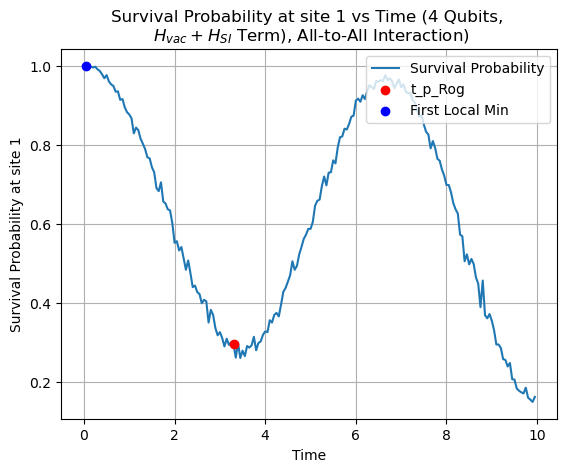

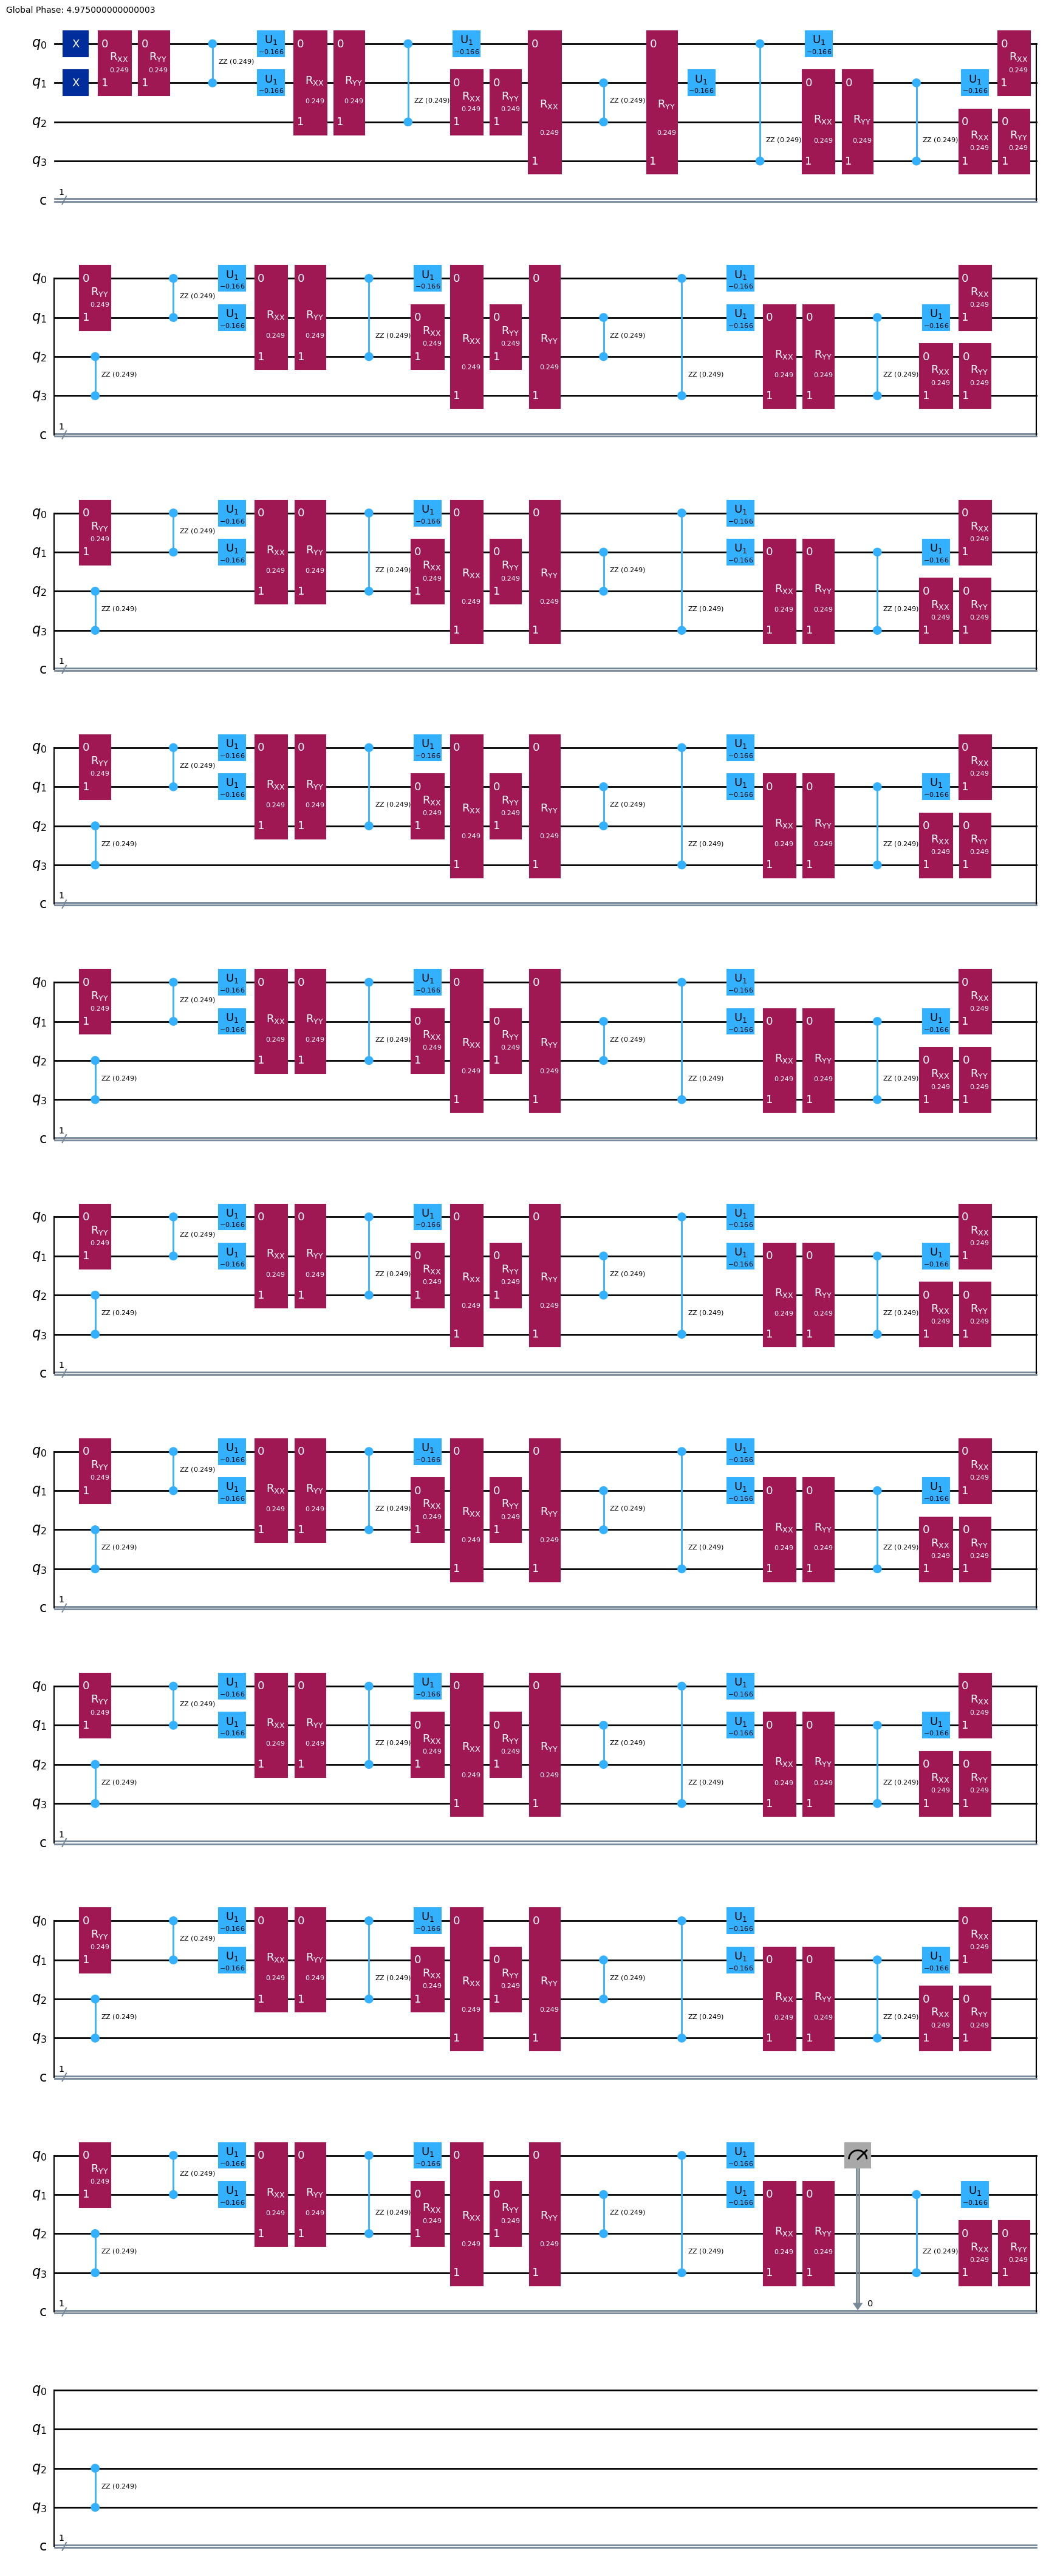

In [20]:
N_sites, theta_nu, omega, B, N, x, p, energy_sign, Δx, Δp, L, delta_m_squared, shape_name , shots, backend, tolerance, τ, times= initialize_parameters()
pauli_terms = construct_hamiltonian(N, omega, B, N_sites, Δx, delta_m_squared, p, x, Δp, theta_nu, shape_name, L, τ, energy_sign)
sigma_z_values, survival_probabilities, t_min, t_p_Rog, i_first_local_min, circuit = simulate(times, omega, N_sites, pauli_terms, backend, shots, τ, tolerance, trotter_order)
plot_results(times, sigma_z_values, survival_probabilities, N_sites, t_min, t_p_Rog, i_first_local_min)
circuit.draw(output="mpl")

In [ ]:
# def main():
#     N_sites, theta_nu, omega, B, N, x, p, energy_sign, Δx, Δp, L, delta_m_squared, shape_name , shots, backend, tolerance, τ, times= initialize_parameters()
#     pauli_terms = construct_hamiltonian(N, omega, B, N_sites, Δx, delta_m_squared, p, x, Δp, theta_nu, shape_name, L, τ, energy_sign)
#     sigma_z_values, survival_probabilities, t_min, t_p_Rog, i_first_local_min, circuit = simulate(times, omega, N_sites, pauli_terms, backend, shots, τ, tolerance, trotter_order)
#     plot_results(times, sigma_z_values, survival_probabilities, N_sites, t_min, t_p_Rog, i_first_local_min)

# if __name__ == "__main__":
#     main()